<a href="https://colab.research.google.com/github/superbunny38/Multi-Object-Semantic-Segmentation/blob/main/preprocess/Lung_Instance_ImagePreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Instance Segmetation of Lung images

**Lung segmentation (left, right 2classes segmentation)**
 - pre-processing (2 class labeling)
 - training (2 class traininig)
 - post-processing (performance enhancement)

# Utils & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans

# Load Data

In [ ]:
import shutil
!mkdir data
#file1 = "/content/drive/MyDrive/train.zip"
#file1 = "/content/drive/MyDrive/ai_competition/train.zip"
file1 = "/content/drive/MyDrive/2022/LungSegmentation/Lung_Segmentation.zip"
shutil.unpack_archive(file1, "/content/data")

# Check data

In [ ]:
import os
train_img_root = "/content/data/image/"
train_img_names = os.listdir(train_img_root)
len(train_img_names)#number of images

566

In [ ]:
train_img_names[0]#check name

'resize_CHNCXR_0138_0.png'

In [ ]:
import os
train_label_root = "/content/data/label/"

In [ ]:
train_label_names = os.listdir(train_label_root)
assert len(train_img_names) == len(train_label_names)#number of labels
train_label_names[0]

'resize_CHNCXR_0138_0.png'

In [ ]:
len(train_label_names)

566

## Sample Image & Label

image sample

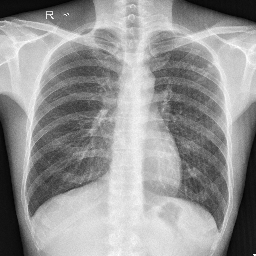

In [ ]:
from PIL import Image
img = Image.open(train_img_root + train_img_names[0])
img

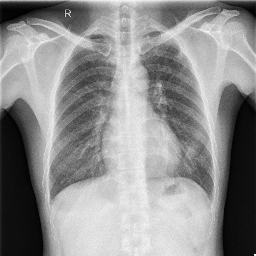

In [ ]:
from PIL import Image
img = Image.open(train_img_root + train_img_names[1])
img

In [ ]:
np.array(img).shape#single channel

(256, 256, 3)

label sample

In [ ]:
train_label_names[0]

'resize_CHNCXR_0539_1.png'

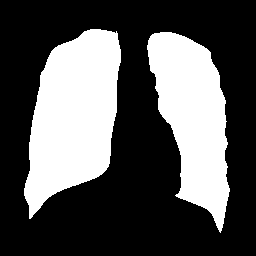

In [ ]:
from PIL import Image
label = Image.open(train_label_root + train_label_names[0])
label

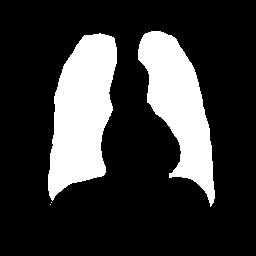

In [ ]:
from PIL import Image
label = Image.open(train_label_root + train_label_names[1])
label

In [ ]:
np.array(label).shape

(256, 256)

In [ ]:
unique_ = np.unique(np.array(label))
unique_

array([  0, 255], dtype=uint8)

In [ ]:
for idx in range(len(train_label_names)):
  label = Image.open(train_label_root + train_label_names[idx])
  assert len(np.unique(np.array(label))) == 2

In [ ]:
np.array(label).shape

(256, 256)

# Label Preprocessing

In [ ]:
def split_label(label):#labeel info: 0: background, 1:left, 2: right
  start_index = 0
  array_label = np.array(label)
  left_lung = np.array(label)
  right_lung = np.array(label)
  found = 0
  while start_index < np.array(label).shape[1]:
    if sum(array_label[:,start_index]) > 0:
      tmp_index = start_index
      while tmp_index < np.array(label).shape[1]:
        tmp_index += 1
        if sum(array_label[:,tmp_index]) == 0:
          found = 1
          mid_index = tmp_index
          left_lung[:,mid_index:] =0.
          right_lung[:,:mid_index] = 0. 
          tmp_left, tmp_right = left_lung, right_lung
          tmp_left[tmp_left == 255.] = 1#left
          tmp_right[tmp_right == 255.] =2#right
          final = tmp_left + tmp_right
          return left_lung, right_lung, final
    else:
      start_index += 1
  assert found == 1
  

In [ ]:
left,right,final = split_label(label)

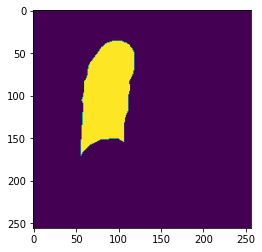

In [ ]:
plt.imshow(left)

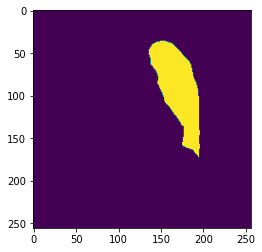

In [ ]:
plt.imshow(right)

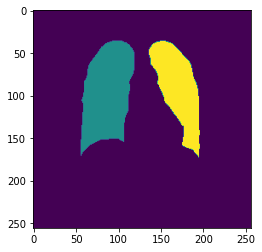

In [ ]:
plt.imshow(final)

In [ ]:
np.unique(final)

array([0, 1, 2], dtype=uint8)

save

In [ ]:
%cd ..

/


In [ ]:
%cd content/

/content


In [ ]:
!mkdir left_lung
!mkdir right_lung

In [ ]:
annotation_dir = '/content/drive/MyDrive/2022/LungSegmentation/annotation/'

In [ ]:
import cv2 
for idx in range(len(train_label_names)):
  label = Image.open(train_label_root + train_label_names[idx])
  left,right,final = split_label(label)
  assert len(np.unique(final)) == 3
  #cv2.imwrite('/content/drive/MyDrive/2022/LungSegmentation/left_lung/'+train_label_names[idx], left)
  #cv2.imwrite('/content/drive/MyDrive/2022/LungSegmentation/right_lung/'+train_label_names[idx], right)
  cv2.imwrite(annotation_dir+train_label_names[idx], final)

In [ ]:
import os
left_lung = "/content/left_lung/"
right_lung = "/content/right_lung/"
assert len(os.listdir(left_lung)) == len(os.listdir(right_lung))

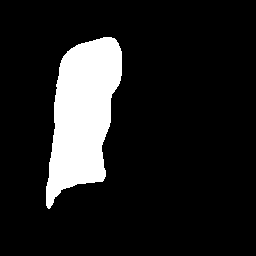

In [ ]:
from PIL import Image
label = Image.open(left_lung+ train_label_names[1])
label

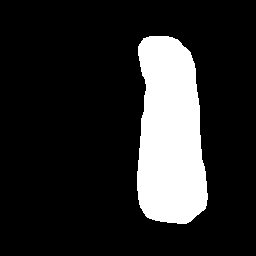

In [ ]:
from PIL import Image
label = Image.open(right_lung+ train_label_names[1])
label

In [ ]:
pwd

'/content'

In [ ]:
!cp -r /content/left_lung /content/drive/MyDrive/2022/LungSegmentation#copy data to gdrive

cp: target 'gdrive' is not a directory


In [ ]:
!cp -r /content/right_lung /content/drive/MyDrive/2022/LungSegmentation#copy data to gdrive

# Prepare multi-class labels in RGB

In [ ]:
!mkdir real_multi_label

In [ ]:
GT_PATH = "/content/"
class_names = ["left_lung/","right_lung/"]
savepath = "/content/real_multi_label"

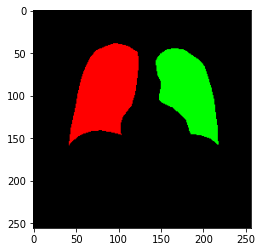

In [ ]:
import cv2 
n_class = 2
left_root = "/content/left_lung/"
right_root = "/content/right_lung/"
for idx in range(len(train_label_names)):
  GT_im=np.zeros(np.concatenate(((256,256),3),axis=None))#RGB

  GT_im[:,:,0] = np.array(Image.open(left_root+train_label_names[idx]))#left: red
  GT_im[:,:,1] = np.array(Image.open(right_root+train_label_names[idx]))#right: green
  #print(GT_im[110,:])
  plt.imshow(GT_im)
  cv2.imwrite('/content/drive/MyDrive/2022/LungSegmentation/multi_GT/'+train_label_names[idx],GT_im)

# Gray-scale Histogram Equalization (3 channel)

In [ ]:
data_dir = '/content/data/image/'
data_img_list = os.listdir(data_dir)

In [ ]:
data_img_list[0]

'resize_CHNCXR_0138_0.png'

In [ ]:
import cv2
src = cv2.imread(data_dir+data_img_list[0])
src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)#convert to gray scale
dst = cv2.equalizeHist(src)

original


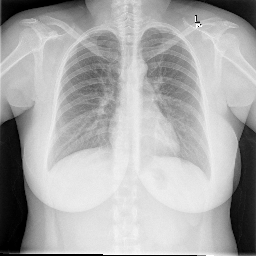

In [ ]:
from google.colab.patches import cv2_imshow
print("original")
cv2_imshow(src)

after histogram equalization


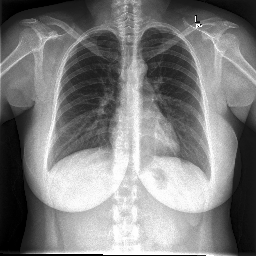

In [ ]:
print('after histogram equalization')
cv2_imshow(dst)

In [ ]:
!mkdir histogram_eq_image

In [ ]:
%cd /content/histogram_eq_image

/content/histogram_eq_image


In [ ]:
!pwd

/content/histogram_eq_image


In [ ]:
from PIL import Image
for i in range(len(data_img_list)):
  src = cv2.imread(data_dir+data_img_list[i])
  src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)#convert to gray scale
  dst = cv2.equalizeHist(src)
  dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
  cv2.imwrite(data_img_list[i],dst)

In [ ]:
check_dir = '/content/histogram_eq_image/'

In [ ]:
names = os.listdir(check_dir)

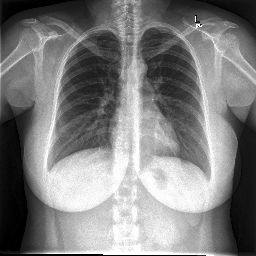

In [ ]:
img = Image.open(names[0])
img

In [ ]:
np.array(img).shape

(256, 256, 3)

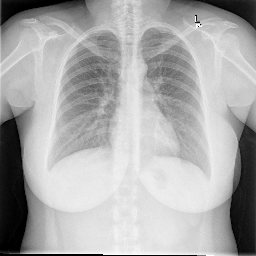

In [ ]:
original_dir = '/content/data/image/'
data_img_list = os.listdir(original_dir)
original = Image.open(original_dir+data_img_list[0])
original

In [ ]:
np.array(original).shape

(256, 256, 3)

In [ ]:
!pwd

/content/histogram_eq_image


In [ ]:
!cp -R /content/histogram_eq_image /content/drive/MyDrive/2022/LungSegmentation/